In [2]:
import os
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from skimage import io, color
from skimage.transform import resize
from sklearn.metrics import jaccard_score, precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torchvision.transforms.functional as TF
from torchvision.models.segmentation import fcn_resnet50

torch.manual_seed(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/home/jk/Documents/faks/sb/seminarska/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class EarDataset(Dataset):

    def __init__(self, path, train=False):
        self.path = path  #"AWEForSegmentation/test" or "AWEForSegmentation/train"

        self.train = train
        
        self.imgs = list(sorted(os.listdir(path)))
        self.masks = list(sorted(os.listdir(path + "annot")))
        self.boxes = list(sorted(os.listdir(path + "annot_rect"))) #just in case

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.path, self.imgs[idx])
        image = io.imread(img_name) / 255
        
        mask = io.imread(os.path.join(self.path + "annot", self.masks[idx]))
        
        box = io.imread(os.path.join(self.path + "annot_rect", self.boxes[idx]))
        
        pos = np.where(box)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        box_coor = torch.as_tensor([xmin, ymin, xmax, ymax])
        
        ## for images in dataset that are grayscale or have alpha channel...
        if len(image.shape) == 2:
            image = image = color.gray2rgb(image)
        elif image.shape[2] == 4:
            image = image[:,:,:3]

        image = torch.tensor(image, dtype = torch.float32)
        image = image.permute(2, 0, 1)

        mask = torch.tensor(mask).unsqueeze(0)

        if self.train:
            image, mask = my_transforms(image, mask)

        return image, mask

def my_transforms(image, mask):

    if np.random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    if np.random.random() > 0.5:
        angle = np.random.randint(-30, 30)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)

        # if np.random.random() > 0.8:
        #     image = TF.adjust_saturation(image, saturation_factor=np.random.uniform(0.95, 1.05))

        # if np.random.random() > 0.8:
        #     image = TF.adjust_hue(image, hue_factor=np.random.uniform(0, 0.05))

        # if np.random.random() > 0.8:
        #     image = TF.adjust_contrast(image, contrast_factor=np.random.uniform(0.95, 1.05))

    #image = TF.normalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        
    return image, mask

In [8]:
dataset = EarDataset(path = "AWEForSegmentation/train", train = True)

def show_dataset(dataset, num):
    for a, b in enumerate(dataset):
        if a>=num:
            break
            
        i, m = b

        img = i.permute(1, 2, 0).detach().cpu().numpy()

        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(img)

        plt.subplot(1, 2, 2)
        plt.imshow(m.squeeze())

        mm = m.detach().cpu().numpy()

# show_dataset(dataset, 3)

In [ ]:
def get_model(device, path_model = None, train = False):

    model = fcn_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

    if path_model:
        print("loading...")

        checkpoint = torch.load(path_model, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

        if train:
            model.to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch_start = checkpoint['epoch']

            return model, optimizer, epoch_start

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    epoch_start = 0

    return model, optimizer, epoch_start
        

In [ ]:
# print(sum(p.numel() for p in model.parameters()))

35306818


In [ ]:
def train(device, train_set, valid_set, path_model_save, model, early_stopping, num_epochs, save = False):

    dataloader_train = DataLoader(train_set, batch_size = 5, shuffle = True, num_workers=4)
    dataloader_valid = DataLoader(valid_set, batch_size = 5, num_workers=4)

    min_loss = {"train": 0, "valid": [0, 0]}  # valid : (min_loss, count_since_min_loss)
    loss_log = {"train": np.array([]), "valid": np.array([])}
    acc_log = {"train": np.array([]), "valid": np.array([])}

    criterion = nn.BCEWithLogitsLoss()
    
    graph_loss = {"train": np.array([]), "valid": np.array([])}
    graph_iou = {"train": np.array([]), "valid": np.array([])}

    t1 = time.time()
    for epoch in range(num_epochs):
        print(f"EPOCH {epoch}:")
        t2 = time.time()

        ### TRAIN

        model.train()
        len_tr = int(len(train_set) / 5)

        for i, batch in tqdm(enumerate(dataloader_train), total=len_tr, position=0, leave=True):
            imgs, masks = batch
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)

            loss = criterion(outputs["out"].float(), masks.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_log["train"] = np.append(loss_log["train"], loss.cpu().detach().numpy().squeeze())
            out = outputs["out"].float().sigmoid().detach().cpu().numpy()
            iou = jaccard_score(out.reshape(-1).round(), masks.detach().cpu().numpy().reshape(-1))
            acc_log["train"] = np.append(acc_log["train"], iou)


        avg_loss_tr = np.mean(loss_log["train"][-len_tr:])
        avg_iou_tr = np.mean(acc_log["train"][-len_tr:])

        graph_loss["train"] = np.append(graph_loss["train"], avg_loss_tr)
        graph_iou["train"] = np.append(graph_iou["train"], avg_iou_tr)

        t3 = time.time()
        print(f"TRAIN: loss: {avg_loss_tr:.3f}, iou: {avg_iou_tr:.3f}")

        ### VALIDATION

        model.eval()
        len_val = int(len(valid_set) / 5)

        for i, batch in tqdm(enumerate(dataloader_valid), total=len_val, position=0, leave=True):
            with torch.no_grad():
                outputs = model(imgs)
            
            loss = criterion(outputs["out"].float(), masks.float())

            loss_log["valid"] = np.append(loss_log["valid"], loss.cpu().detach().numpy().squeeze())
            out = outputs["out"].float().sigmoid().detach().cpu().numpy()
            iou = jaccard_score(out.reshape(-1).round(), masks.detach().cpu().numpy().reshape(-1))
            acc_log["valid"] = np.append(acc_log["valid"], iou)


        avg_loss = np.mean(loss_log["valid"][-len_val:])
        avg_iou = np.mean(acc_log["valid"][-len_val:])

        graph_loss["valid"] = np.append(graph_loss["valid"], avg_loss)
        graph_iou["valid"] = np.append(graph_iou["valid"], avg_iou)

        t4 = time.time()
        
        print(f"VALIDATION: loss: {avg_loss:.3f}, iou: {avg_iou:.3f}")
                           
        if min_loss["valid"][0] == 0:
            min_loss["valid"][0] = avg_loss

        elif avg_loss < min_loss["valid"][0] and abs(avg_loss - min_loss["valid"][0]) > 1e-5:
            min_loss["valid"] = [avg_loss, 0]
            
            torch.save({
                        'epoch': epoch + epoch_start, 
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': avg_loss,
                        'acc' : avg_iou
                        }, path_model_save)
            print("Saving model...")

        else:
            min_loss["valid"][1] += 1

        if early_stopping > 0 and min_loss["valid"][1] > early_stopping:
            print("*******EARLY STOPPING*******")
            t5 = time.time()
            print(f"Elapsed time: {(t5-t1)/60} min")
            return graph_loss, graph_iou

        print("-"*80)

    t5 = time.time()
    print(f"Elapsed time: {(t5-t1)/60} min")
    return graph_loss, graph_iou

dataset = EarDataset(path = "AWEForSegmentation/train", train = False) ############ <--- no aug when train=false
train_size = int(len(dataset) * 0.8)
valid_size = int(len(dataset) - train_size)

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
model, optimizer, epoch_start = get_model(device, path_model = None, train=True)

path_model = "model-base-19.pt"
graph_loss, graph_iou = train(device, train_dataset, valid_dataset, path_model_save = path_model, model = model, early_stopping=-1, num_epochs=19)


EPOCH 0:


In [ ]:
def test(device, model, dataset):

    dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers=4)

    model.eval()
    metrics = {"iou": [], "pre": [], "rec": []}

    criterion = nn.BCEWithLogitsLoss()

    for i, batch in tqdm(enumerate(dataloader), total=len(dataset), position=0, leave=True):
        imgs, masks = batch
        imgs = imgs.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outputs = model(imgs)
        
        loss = criterion(outputs["out"].float(), masks.float())
        
        out = outputs["out"].float().sigmoid().detach().cpu().numpy()

        pred = out.reshape(-1).round() 
        ref = masks.detach().cpu().numpy().reshape(-1)

        iou = jaccard_score(pred, ref)
        pre = precision_score(pred, ref)
        rec = recall_score(pred, ref)

        metrics["iou"].append(iou)
        metrics["pre"].append(pre)
        metrics["rec"].append(rec)

        # if iou < 0.5:
        #     print("**************OOPS**************")
        #     plt.figure(figsize=(20, 8))        

        #     plt.subplot(1, 3, 1)
        #     plt.title(f"prediction, iou: {iou:.3f}")
        #     plt.axis("off")
        #     plt.imshow(out[0].squeeze(), cmap='gray')

        #     plt.subplot(1, 3, 2)
        #     plt.title("mask")
        #     plt.axis("off")
        #     plt.imshow(masks[0].detach().cpu().numpy().squeeze(), cmap='gray')
        #     #print(np.unique(masks[0].detach().cpu().numpy().squeeze()))

        #     plt.subplot(1, 3, 3)
        #     plt.title("image")
        #     plt.axis("off")
        #     plt.imshow(imgs[0].detach().cpu().permute(1, 2, 0).numpy().squeeze())

        #     #plt.savefig(f"/content/drive/MyDrive/slika-{i}", bbox_inches="tight")

    iou = np.mean(metrics["iou"])
    pre = np.mean(metrics["pre"])
    rec = np.mean(metrics["rec"])
    print(f"IoU: {iou:.5f}, Precision: {pre:.5f}, Recall: {rec:.5f}")

dataset = EarDataset(path = "AWEForSegmentation/test")
model, _, _ = get_model(device, path_model = "model-base-19.pt")

test(device, model, dataset)

loading...


loading...


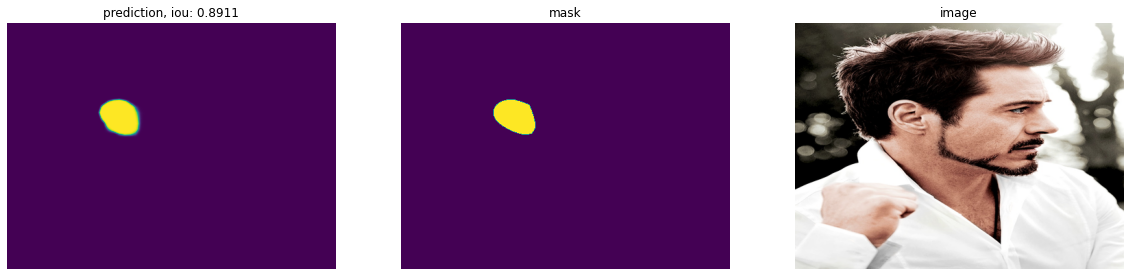

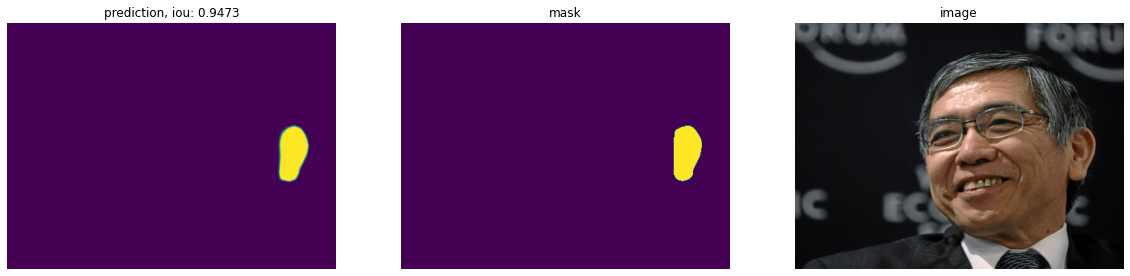

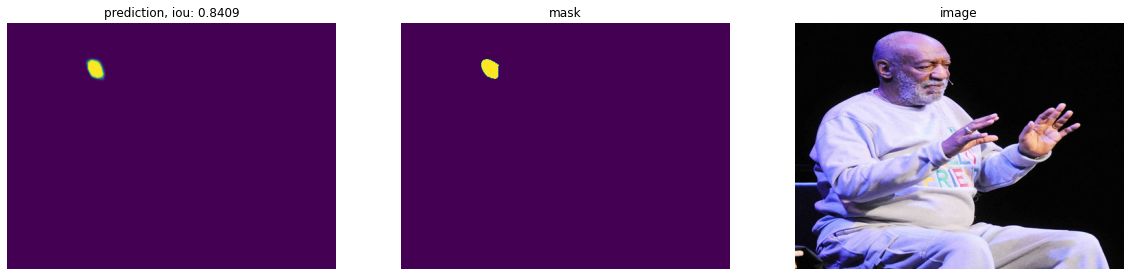

In [ ]:
def show_results(device, model, dataset, num):

    dataloader = DataLoader(dataset, batch_size = 1, shuffle = True)

    model.eval()
    avg_iou = []

    criterion = nn.BCEWithLogitsLoss()

    for i, batch in tqdm(enumerate(dataloader), total=num-1, position=0, leave=True):
        imgs, masks = batch
        imgs = imgs.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outputs = model(imgs)
        
        loss = criterion(outputs["out"].float(), masks.float())
        out = outputs["out"].float().sigmoid().detach().cpu().numpy()

        iou = jaccard_score(out.reshape(-1).round(), masks.detach().cpu().numpy().reshape(-1))
        #print(f"batch: {i}, iou: {iou}")

        avg_iou.append(iou)
        # print(out.shape)
        #print(np.unique(out))
        plt.figure(figsize=(20, 8))        

        plt.subplot(1, 3, 1)
        plt.title(f"prediction, iou: {iou:.4f}")
        plt.axis("off")
        plt.imshow(out[0].squeeze())

        plt.subplot(1, 3, 2)
        plt.title("mask")
        plt.axis("off")
        plt.imshow(masks[0].detach().cpu().numpy().squeeze())
        #print(np.unique(masks[0].detach().cpu().numpy().squeeze()))

        plt.subplot(1, 3, 3)
        plt.title("image")
        plt.axis("off")
        plt.imshow(imgs[0].detach().cpu().permute(1, 2, 0).numpy().squeeze())
        if i>=num-1:
            return

    #print(np.mean(avg_iou))

dataset = EarDataset(path = "AWEForSegmentation/test")

model, _, _ = get_model(device, path_model = "model-base-19.pt")

show_results(device, model, dataset, num=3)